# 0. Introduction
By Xuyang (Rhett) Zhou at Max-Planck-Institut für Eisenforschung GmbH, 2021/06/10 17:56

This code aims to convert Tvips - 4DSTEM data to BLO file.

The most important thing for the conversion process is to find the first frame where the 4DSTEM data acquisition starts.

Step 1 provides an automated way to find such a frame. This automated method works for the data set that has a significant change in the content of the diffraction frames before and after the start of the scan, otherwise manual selection by checking individual diffraction parts is also supported in this code.

Step 2 generates a section of the virtual brightfield image to confirm that the user finds the correct frame at which the scan starts.

Step 3 performs the conversion of the data set from the Tvips file to the BLO file. Batch conversion is supported.

Requirement: This script has been tested on Python 3.7.3. Please pip install any packages that are missing on your computer.

# Import useful functions

In [1]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os
import cv2
import math
import os
from tkinter import filedialog
from scipy.signal import find_peaks
from skimage.metrics import structural_similarity as ssim

# Define functions for the following calculation
def load_image(numframe,hf_path,digit,scale):
    # load one images from local, digit is for file name, 
    # scale is for reducing image size
    hf = h5py.File(hf_path, 'r')
    group = hf.get('Individual_Images')
    file_name = 'frame_' + str(numframe).zfill(digit)
    n1 = group.get(file_name)
    image = np.array(n1)
    image = resize_image(image,scale)
    image_set = (str(numframe).zfill(digit),image)
    hf.close()
    return image_set

def load_images(numframes,hf_path,digit,scale):
    # load the images from local, digit is for file name,
    # scale is for reducing image size
    hf = h5py.File(hf_path, 'r')
    group = hf.get('Individual_Images')
    images = ()
    for i in range(0,numframes):
        file_name = 'frame_' + str(i).zfill(digit)
        n1 = group.get(file_name)
        image = np.array(n1)
        image = resize_image(image,scale)
        image_set = (str(i).zfill(digit),image)
        images = images + (image_set,)
    hf.close()
    return images

def virtual_bf_mask(image, centeroffsetpx=(0.0), radiuspx=10):
    # Set a mask for the image, find the center beam
    xx, yy = np.meshgrid(np.arange(image.shape[0], dtype=np.float), np.arange(image.shape[1], dtype=np.float))
    xx -= 0.5 * image.shape[0] + centeroffsetpx[0] 
    yy -= 0.5 * image.shape[1] + centeroffsetpx[1]

    mask = np.hypot(xx,yy)<radiuspx
    return mask

def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

def compare_images(imageA, imageB):
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)
    return m,s

def resize_image(img,scale_percent):
    # resize the image, make image smaller
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

def add_mask(mask,frame):
    mask_cb = np.multiply(~mask,1)
    frame = np.multiply(mask_cb,frame)
    return frame

def find_start(images,mask,show_images,show_ss):
    # find the starting frame, if show_images == True, plot images
    num_images = len(images)
    s_all = np.full([num_images], np.nan)
    if show_images == True: 
        cols = 5
        rows = np.ceil(num_images/cols)
        fig = plt.figure("Images")
        fig.set_size_inches(cols*3, rows*3)
    # loop over the images
    for (i, (name, image)) in enumerate(images):
        if i == 0:
            imageA = add_mask(mask,images[i][1])
            imageB = add_mask(mask,images[i][1])
        else:
            imageA = add_mask(mask,images[i-1][1])
            imageB = add_mask(mask,images[i][1])
        m,s = compare_images(imageA, imageB)
        s_all[i] = s
        if show_images == True:
            plt.subplot(rows, cols, i+1)
            #title = name + '_' + "%d" % m + '_' + "%.e" % s
            title = name
            plt.title(title)
            plt.imshow(imageB, cmap = plt.cm.gray)
            plt.axis("off")
    
    n = 3                    # Number of guessing frames
    frames_bw_peaks = 20     # Minimum frames between adjacent peaks
    index = np.zeros(3,dtype=int)
    peaks,_ = find_peaks(-s_all,distance=frames_bw_peaks)
    smallest_indices = np.argsort(s_all[peaks])[:n]
    peak_values = s_all[peaks][smallest_indices]
    index[0] = np.where(s_all[:] == peak_values[0])[0][0]
    index[1] = np.where(s_all[:] == peak_values[1])[0][0]
    index[2] = np.where(s_all[:] == peak_values[2])[0][0]
    index = np.sort(index)
    
    if show_images == True:
        plt.show()
    if show_ss == True:
        fig = plt.figure("Structural similarity")
        plt.plot(s_all[1:])
        plt.plot(index,s_all[index],'x')
        for i,value,txt in np.broadcast(index,s_all[index],index):
            plt.annotate(txt, (i,value))
        plt.ylabel('Structural similarity')
        plt.xlabel('Frames')
        plt.yscale("log")
        plt.show()
    print(index)
    return index

# 1. Find the starting frame

## 1.1 Load the data
Note: This step is used to select a TVIPS file for analysis.

In [2]:
# Set parameters start
linescale = "1-100"           # Scale factor of the intensity of the diffraction image
numframes = 500               # Estimate a number that covers the first frame of 4DSTEM scan,
                              # This value depends on how fast you started your scan after clicking acquisition.
                              # Normally it should be less than 1000.
# Set parameters end

In [3]:
# Run the functions
# There maybe several files cooresponding to one data set (due to large size)
# select the one with the end "_000.tvips"
file_path = filedialog.askopenfilename(title='Choose a *.tvips file',\
                                   filetypes=[("TVIPS","*.tvips")])
file_name = os.path.split(file_path)[1]  # Get the name of the analysed file
fold_path = os.path.split(file_path)[0]
file_name_hf = file_name[:-10] + '.h5'
hf_path = os.path.join(fold_path, file_name_hf)
run_string = 'python ./tvips/recorderR.py --otype=Individual --linscale=' + linescale + \
            ' --numframes=' + str(numframes) + ' ' + file_path + ' ' + hf_path
os.system(run_string)

0

## 1.2 Check the position of the mask
Note: This step is to check the position of center beam by using mask.

This size of the mask should be slightly larger than the transmit (center spot) beams.

A correct mask helps to locate the first image and to create a virtual bright field image.

In [4]:
# Set parameters start
which_frame = 5          # which frame to check, this value should be smaller than numframes
offset = [-1,0]          # off-set pixels for mask, based on raw image, modify to shift the mask
radius = 20              # mask radius, based on raw image, modify to change the size
alpha = 0.5              # alpha for overlapping mask to image, use default
# Set parameters end

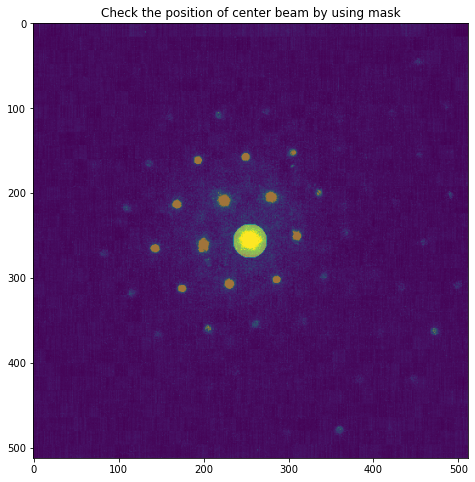

In [5]:
# Run the functions
if which_frame > numframes:
    which_frame = numframes
digit = len(str(numframes-1))                    # for file name
image = load_image(which_frame,hf_path,digit,100)
mask = virtual_bf_mask(image[1], offset, radius)
mask_cb = np.multiply(mask,1)
fig = plt.figure("Mask")
fig.set_size_inches(8, 8)
plt.imshow(image[1])
plt.imshow(mask_cb,alpha=alpha)
plt.title("Check the position of center beam by using mask")
plt.show()

## 1.3 Check the position of the mask
Note: This step is used to find the first image where the 4DSTEM data acquisition starts.

Our script gives three possible solutions. The first one will be the default value for the next step.

The user can also select the number of the first frame by checking the diffraction patterns.

In [6]:
# Set parameters start
scale_percentage = 20    # for resizing the diffraction image, reducing this number can increase the speed of calculation
show_images = False      # Change to determine whether to plot individual images
show_ss = True          # Change to determine whether to plot structural similarity values
# Set parameters end

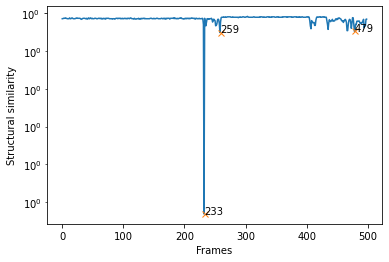

[233 259 479]


In [7]:
# Run the functions
images = load_images(numframes,hf_path,digit,scale_percentage)
scale_radius = int((scale_percentage*radius)/100)
scale_offset = [int((scale_percentage*offset[0])/100),\
             int((scale_percentage*offset[1])/100)]
mask = virtual_bf_mask(images[0][1], scale_offset, scale_radius)
guess_first_frame = find_start(images,mask,show_images,show_ss)

# 2. Check the virtual bright field image

## 2.1 Generate a virtual bright field image
Note: This step is used to display a section of the virtual brightfield image to test whether the number of start image is correct

In [8]:
# Set parameters start
vbf_h = 20                    # set the height of the virtual bright field image, 20 pixels should be good enough
vbf_w = 276                   # set the width of the virtual bright field image, 
                              # this value depends on your setting during data acquisition
use_auto = 0                  # If use_auto equals 0,1,or,2, use the guessed values in step 1; 
                              # elseif use_auto equals 3,use the guess from the users
my_guess_first_frame = 100    # The guess of the first frame from the user, useful only use_auto = 3
# Set parameters end

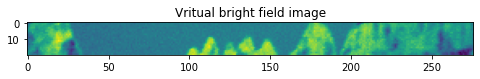

In [9]:
# Run the functions
if use_auto < 3:
    first_frame = guess_first_frame[use_auto]
else:
    first_frame = my_guess
numframes_vbf = vbf_h*vbf_w + first_frame
run_string = 'python ./tvips/recorderR.py --otype=VirtualBF --linscale=' + linescale + \
            ' --numframes=' + str(numframes_vbf) + ' --vbfradius=' + str(radius) + \
            ' --vbfcenter='+ str(offset[0]) + 'x' + str(offset[1]) + \
            ' --dimension='+ str(vbf_h) + 'x' + str(vbf_w) + ' --skip=' + str(first_frame) + \
            ' ' + file_path + ' ' + hf_path
os.system(run_string)
hf = h5py.File(hf_path, 'r')
g1 = hf.get('Virtual_bright_field')
file_name_vbf1 = 'Virtual_bright_field'
n1 = g1.get(file_name_vbf1)
vbf = np.array(n1)
hf.close()
fig = plt.figure("Vritual bright field image")
fig.set_size_inches(8, 8)
plt.imshow(vbf)
plt.title("Vritual bright field image")
plt.show()

## 2.2 Save the parameters for conversion
Note: This step saves the obtained parameters into ".h5" for later batch conversion

In [10]:
# Set parameters start
blo_h = 255                   # set the height of the blo file, 255 (pixels) is the default value
# Set parameters end

In [11]:
# Run the functions
hf = h5py.File(hf_path, 'r+')
g1_name = 'Parameters_for_conversion'
if g1_name in hf.keys():
    del hf[g1_name]
g1 = hf.create_group(g1_name)
g1.create_dataset('Starting_frame',data=first_frame)
g1.create_dataset('Image_height',data=blo_h)
g1.create_dataset('Image_width',data=vbf_w)
g1.create_dataset('Image_constrast',data=linescale)
g1.create_dataset('File_path',data=file_path)
g1.create_dataset('Diff_size',data=image[1][0].size)
hf.close()

# Before Step 3, Repeat Step 1-2 for all interested TVIPS data set

# 3. Perform the conversion

Note: This step executes the conversion from ".tvips" file to ".h5" file

In [12]:
# Set parameters start
binning = 1                   # set the binning factor, should be 2^n, i.e., 1,2,4,8,...
use_filter = True           # If True, each diffraction image will be processed before storing 
median = 4                    # Parameter for the filter 
gaussian = '4,2.0'            # Paramete for the filter
file_list = []                # This line and following 5 lines are for selecting mutiple "*.h5" files for batch exporting
fn = ['1']                    # click "cancel" if the selection process is done 
while fn:
    fn = filedialog.askopenfilename(title='Choose a *.h5 file',\
                                   filetypes=[("HDF5","*.h5")])
    file_list.append(fn)
# Set parameters end

In [13]:
# Run the functions
run_string_0 = 'python ./tvips/recorderR.py --otype=blo'
if use_filter == True:
    filter_string = ' --median=' + str(median) + ' --gaussian=' + gaussian
else:
    filter_string = ''
if binning == 1:
    binning_string = ''
else:
    binning_string = ' --binning=' + str(binning)
for file in file_list[:-1]:
    hf = h5py.File(file, 'r')
    g1_name = 'Parameters_for_conversion'
    n1 = hf.get(g1_name)
    linescale_string = ' --linscale=' + n1.get('Image_constrast')[()]
    image_string = ' --dimension=' + str(n1.get('Image_height')[()]) + 'x' + str(n1.get('Image_width')[()])
    skip_string = ' --skip=' + str(n1.get('Starting_frame')[()])
    file_path_string = ' ' + n1.get('File_path')[()]
    diff_size_value = n1.get('Diff_size')[()]
    diff_size_value = int(diff_size_value/binning)
    hf.close()
    if use_filter == True:
        blo_path_string = file_path_string[:-10] + '_' + str(diff_size_value) + 'F.blo'
    else:
        blo_path_string = file_path_string[:-10] + '_' + str(diff_size_value) + '.blo'
        
    run_string = run_string_0 + linescale_string + binning_string + image_string + \
                skip_string + filter_string + file_path_string + blo_path_string
    print(run_string)
    os.system(run_string)

python ./tvips/recorderR.py --otype=blo --linscale=1-100 --dimension=255x276 --skip=233 --median=4 --gaussian=4,2.0 G:/4DSTEM/test_tvipsBlo/ROI1/PtAu_03_04I_ROI1_20210526_140447_000.tvips G:/4DSTEM/test_tvipsBlo/ROI1/PtAu_03_04I_ROI1_20210526_140447_512F.blo
python ./tvips/recorderR.py --otype=blo --linscale=1-100 --dimension=255x276 --skip=210 --median=4 --gaussian=4,2.0 G:/4DSTEM/test_tvipsBlo/ROI2/Pt_01_01_20210423_120648_000.tvips G:/4DSTEM/test_tvipsBlo/ROI2/Pt_01_01_20210423_120648_512F.blo


# END